In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob

In [21]:
def calculate_error_bounds(ds):
    
    if 'ensemble_member' in list(ds.dims): 
        pem = ds.mean(dim = 'ensemble_member')
        psd = ds.std(dim = 'ensemble_member', ddof=1)
    else:
        pem = ds.mean(dim = 'member')
        psd = ds.std(dim = 'member')
    
    upperbound = pem + psd
    upperbound['aice'] = upperbound.aice.where(upperbound.aice < 1, 1)
    lowerbound = pem - psd 
    
    return upperbound, lowerbound, pem

#### Get cases

Allowed ridging (the good one)... 

In [4]:
case_list = ['SIT_f101_BNRH_test', 'SIC_f101_BNRH_test','AIC_f101_BNRH_test']

CASES = []
for case in case_list:
    ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/'+case+'/postprocessed_ens.nc')
    ds = ds.isel({'ni':2})
    ds['vice'] = ds.vicen.sum(dim='ncat')
    ds['aice'] = ds.aicen.sum(dim='ncat')
    ds['hi'] = ds.vice/ds.aice
    
    if 'vsnon' in list(ds.keys()):
        ds['vsno'] = ds.vsnon.sum(dim='ncat')
    else: 
        ds['vsno'] = ds.vsno01 + ds.vsno02 + ds.vsno03 + ds.vsno04 + ds.vsno05
    
    CASES.append(ds)

Append restricted ridging (the meh ones) onto the good ones...

In [3]:
SIT_f101_BNRH = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/FREE_ATM/SIT_f101_BNRH_postprocessed_ens.nc')
SIC_f101_BNRH = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/FREE_ATM/SIC_f101_BNRH_postprocessed_ens.nc')
AIC_f101_BNRH = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/FREE_ATM/AIC_f101_BNRH_postprocessed_ens.nc')

In [5]:
CASES.append(SIT_f101_BNRH)
CASES.append(SIC_f101_BNRH)
CASES.append(AIC_f101_BNRH)

#### Get FREE ensembles

The good one

In [6]:
free_ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/FREE/free_ens.nc')
free_ds = free_ds[['aice','vice','hi','vsno','aicen','vicen','vsnon']]

The meh one

In [7]:
free_ATM = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/FREE_ATM/free_ATM.nc')
free_ATM = free_ATM.sel(time=slice('2011-01-02','2011-12-31'))
free_ATM = free_ATM[['aice','vice','vsno','aicen','vicen','vsnon']]

In [8]:
free_ATM['hi'] = free_ATM.vice/free_ATM.aice

#### Get respective observations 

In [9]:
file = "/glade/work/mollyw/Projects/cice-scm-da/data/processed/synthetic_obs/free_test/netcdfs/itd_observations.nc"
obs_test = xr.open_dataset(file)
truth = obs_test.sel({"copy": 2})

SHEBA_aice4_obs = truth.observations[8:365*10:10].values
SHEBA_aice5_obs = truth.observations[9:365*10:10].values

SHEBA_vice4_obs = truth.observations[3:365*10:10].values
SHEBA_vice5_obs = truth.observations[4:365*10:10].values

x = truth.time[0:365*10:10]

SHEBA_sno4_obs = free_ds.isel({'ensemble_member':13}).vsnon.isel({'ncat':3}).values
SHEBA_sno5_obs = free_ds.isel({'ensemble_member':13}).vsnon.isel({'ncat':4}).values

# ATM_sic_obs = free_ATM.isel({'member':13}).aice.values
# ATM_sit_obs = free_ATM.isel({'member':13}).hi.values
# ATM_sno_obs = free_ds.isel({'ensemble_member':13}).vsno.values

ATM_aice4_obs = free_ATM.isel({'member':13}).aicen.isel({'ncat':3}).values
ATM_aice5_obs = free_ATM.isel({'member':13}).aicen.isel({'ncat':4}).values

ATM_vice4_obs = free_ATM.isel({'member':13}).vicen.isel({'ncat':3}).values
ATM_vice5_obs = free_ATM.isel({'member':13}).vicen.isel({'ncat':4}).values

ATM_sno4_obs = free_ATM.isel({'member':13}).vsnon.isel({'ncat':3}).values
ATM_sno5_obs = free_ATM.isel({'member':13}).vsnon.isel({'ncat':4}).values


#### Look at the last two categories 

/glade/scratch/mollyw/ipykernel_187753/4282852756.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=10, rotation = 45)
/glade/scratch/mollyw/ipykernel_187753/4282852756.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=10, rotation = 45)


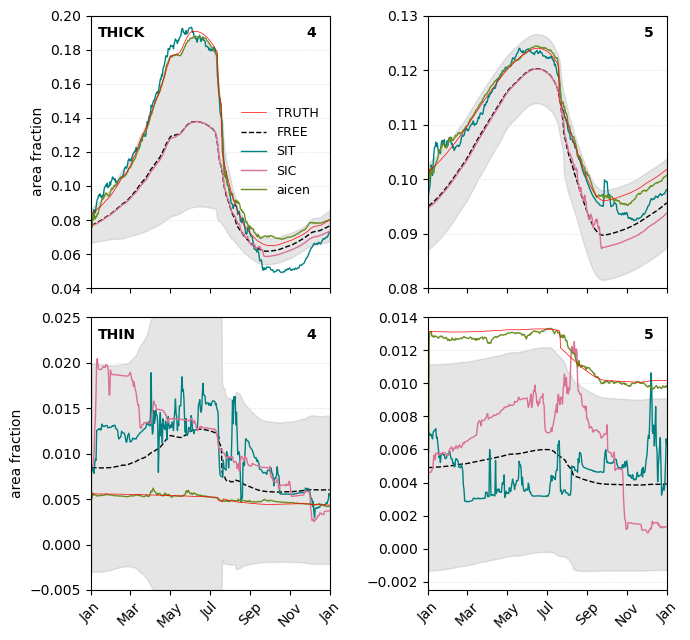

In [20]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(7,6.5))

colors = ['teal','palevioletred','olivedrab']
labels = ['SIT','SIC','aicen']
titles = ['aicen','vicen','vsnon']

fup, flw, fem = calculate_error_bounds(free_ds)
aup, alw, aem = calculate_error_bounds(free_ATM)

axes[0][0].plot(x, SHEBA_aice4_obs, color = 'red', linewidth = 0.5, label = 'TRUTH', zorder = 5)
axes[1][0].plot(x, ATM_aice4_obs, color = 'red', linewidth = 0.5, label = 'TRUTH', zorder = 5)

axes[0][0].set_ylim([0.04, 0.2])
axes[0][1].set_ylim([0.08, 0.13])

axes[0][1].plot(x, SHEBA_aice5_obs, color = 'red', linewidth = 0.5, label = 'TRUTH', zorder = 5)
axes[1][1].plot(x, ATM_aice5_obs, color = 'red', linewidth = 0.5, label = 'TRUTH', zorder = 5)

axes[1][0].set_ylim([-0.005, 0.025])
axes[1][1].set_ylim([-0.0025, 0.014])

for i in range(3, 5):
    
    axes[0][i-3].plot(x, fem.aicen.isel(ncat=i), color = 'black', linewidth = 1, linestyle='dashed', label = 'FREE')
    axes[0][i-3].fill_between(x, flw.aicen.isel(ncat=i), fup.aicen.isel(ncat=i), alpha=0.2, color = 'grey')
    
    axes[1][i-3].plot(x, aem.aicen.isel(ncat=i), color = 'black', linewidth = 1, linestyle='dashed', label = 'FREE')
    axes[1][i-3].fill_between(x, alw.aicen.isel(ncat=i), aup.aicen.isel(ncat=i), alpha=0.2, color = 'grey')
               
    for count in range(0, len(CASES)):

        if count < 3:
            pup, plw, pem = calculate_error_bounds(CASES[count])
            # Effect on volume categories
            axes[0][i-3].plot(x, pem.aicen.isel(ncat=i), color = colors[count], linewidth = 1, label = labels[count])

        else: 
            axes[1][i-3].plot(x, CASES[count].aicen.isel(ncat=i), color = colors[count-3], linewidth = 1, label = labels[count-3])


    axes[0][i-3].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    axes[0][i-3].set_xticklabels('')
    axes[0][i-3].set_xlim([365*41+10, 365*42+10])

    axes[1][i-3].grid(axis='y', color = '0.9', linewidth = 0.5, linestyle = 'dashed', zorder = 0)
    axes[1][i-3].set_xticklabels('')
    axes[1][i-3].set_xlim([365*41+10, 365*42+10])
    
    axes[0][i-3].text(0.9, 0.92, str(i+1),
                transform=axes[0][i-3].transAxes,
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round", edgecolor="white", facecolor='white', alpha=0.5))
    axes[1][i-3].text(0.9, 0.92, str(i+1),
                transform=axes[1][i-3].transAxes,
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round", edgecolor="white", facecolor='white', alpha=0.5))
    
axes[0][0].text(0.03, 0.92, 'THICK',
                transform=axes[0][0].transAxes,
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round", edgecolor="white", facecolor='white', alpha=0.5))
axes[1][0].text(0.03, 0.92, 'THIN',
                transform=axes[1][0].transAxes,
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round", edgecolor="white", facecolor='white', alpha=0.5))

axes[0][0].legend(frameon=False, fontsize=9, loc = 'center right')

axes[1][0].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=10, rotation = 45)
axes[1][1].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov','Jan'], fontsize=10, rotation = 45)
axes[0][0].set_ylabel('area fraction',fontsize=10)
axes[1][0].set_ylabel('area fraction',fontsize=10)

plt.tight_layout()
plt.savefig('figures/small_category_lineplots.png', dpi=300, bbox_inches='tight')